# Joint Mixture Models for Geotagged Tweet Analysis

This notebook demonstrates the use of **Joint Mixture Models** to analyze the relationship between Twitter posts and their geographic locations.

## Joint Mixture Model Framework

A joint mixture model allows us to model the joint distribution of two related variables through a hierarchical mixture structure. The key idea is that we have:

- **Primary mixture component** $Z_0$: Controls the first variable $X_0$ (hashtags/words)
- **Secondary mixture component** $Z_1$: Controls the second variable $X_1$ (geographic location)
- **Coupling**: The secondary component distribution depends on the primary component

### Mathematical Formulation

The joint distribution is factored as:

$$
P(X_0, X_1, Z_0, Z_1) = P(X_1 \mid Z_1) \cdot P(X_0 \mid Z_0) \cdot P(Z_1 \mid Z_0) \cdot P(Z_0)
$$

Breaking this down:

1. **$P(Z_0 = z_0)$**: Prior probability of primary topic $z_0$ (e.g., topic about food, sports, etc.)

2. **$P(X_0 \mid Z_0 = z_0)$**: Likelihood of observing hashtags/words given topic $z_0$

3. **$P(Z_1 = z_1 \mid Z_0 = z_0)$**: Conditional probability of geographic cluster $z_1$ given topic $z_0$  
   This captures the relationship: "If a tweet is about topic $z_0$, where is it likely located?"

4. **$P(X_1 \mid Z_1 = z_1)$**: Likelihood of observing location $X_1$ given geographic cluster $z_1$

### Application to Geotagged Tweets

In this notebook, we apply this framework to understand:

- **$X_0$**: Hashtags and words in tweets (discrete sequence data)
- **$X_1$**: Geographic coordinates (latitude, longitude) as continuous 2D data
- **$Z_0$**: Latent topics (e.g., "food", "sports", "politics")
- **$Z_1$**: Geographic regions or clusters

**Key Questions We Can Answer:**

1. How do different the geographic distributions of topics differ?
2. What are the most common topics discussed in different geographic regions?
3. Given a hashtag (e.g., #food, #london) from a set of hashtags, where is it most likely to be tweeted from? 

The model learns:
- Topic-word distributions (which words/hashtags belong to which topics)
- Geographic cluster centers (where tweets are concentrated)
- Topic-geography coupling (which topics are associated with which regions)

---

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import datetime

from dmx.stats import *
from dmx.utils.estimation import optimize, iterate
import dmx.utils.optsutil as ops

PATH_TO_DATA = "../data"

Let's read the data in and take a look at what the entries look like. 

In [2]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'tweets', 'geo_tweet_small.csv'))
used_data = list(df[['Tweet content', 'Date', 'Hour', 'Latitude', 'Longitude']].values)
used_data[1]

array(['Back For Good by Take That is #nowplaying in Spring Cottage, Walsall.',
       '2016-04-17', '05:01', 52.61635607, -2.00813866], dtype=object)

We are going to load in some stop words to help preprocess the tweets.

In [3]:
fin = open(os.path.join(PATH_TO_DATA, 'stop_words', 'mallet.txt'), 'rt')
sword_set = set(fin.read().split('\n'))
fin.close()

We are going to preprocess our tweeets before we look to fit a model.

In [4]:
def pack_tweets(x: tuple[str, str, str, float, float]) -> tuple[list[str], list[str], float, float, int]:
    r"""
    Parse and extract structured information from a raw tweet entry.
    
    Takes a raw tweet record and extracts hashtags, words (filtered by stop words),
    geographic coordinates, and date information. The function performs text cleaning,
    tokenization, and date formatting.
    
    Args:
        x (tuple): A tuple containing 5 elements [tweet, date, hour, latitude, longitude]
            - tweet (str): The raw tweet content text
            - date (str): Date string in format 'YYYY-MM-DD'
            - hour (str): Time string in format 'HH:MM'
            - latitude (float): Latitude coordinate of tweet origin
            - longitude (float): Longitude coordinate of tweet origin
    
    Returns:
        tuple: A 5-tuple containing:
            - htags (list[str]): List of hashtags found in tweet (e.g., ['#food', '#yum'])
            - words (list[str]): List of words after removing stop words and hashtags
            - lat (float): Latitude coordinate
            - lon (float): Longitude coordinate
            - date (int): Date as integer in format YYYYMMDD (e.g., 20251201)
    
    Notes:
        - All text is converted to lowercase
        - URLs matching https?://\S+ pattern are extracted but not returned
        - Stop words from the global sword_set are filtered out
        - Ellipsis character '…' is removed during processing
    """
    
    tweet, d, h, lat, lon = x
    
    parts = re.findall(r'(#[a-z0-9]+)|(https?://\S+)|([a-z0-9]+)', tweet.lower().replace('…', ''))
    htags = [v[0] for v in filter(lambda u: len(u[0]) > 0, parts)]
    words = [v[2] for v in filter(lambda u: len(u[2]) > 0, parts)]
    words = list(filter(lambda u: u not in sword_set, words))
    date = datetime.datetime.strptime(d + ' ' + h, '%Y-%m-%d %H:%M')
    date = int(date.strftime('%Y%m%d'))
    
    return htags, words, lat, lon, date

Let's call our helper function to process the data. We should see that each entry in `packed_data` is a `tuple` of

1. A list of the hashtags (possibly empty).
2. List of words after removing the stop words.
3. Lattitude
4. Longitude
5. Integer representtion of the date.


In [5]:
packed_data = list(map(pack_tweets, used_data))
packed_data[0]

(['#ukweather'],
 ['tmp',
  '12',
  '9',
  'wind',
  '8mph',
  'press',
  '1027',
  '0mb',
  'cloud',
  '4638',
  'ft',
  'rain',
  '0',
  '0mm',
  'humidity',
  '46',
  'settled',
  'fine'],
 51.33222222,
 -0.55777778,
 20160419)

Now let's plot the geotweet locations (lat, lon) pairs. 

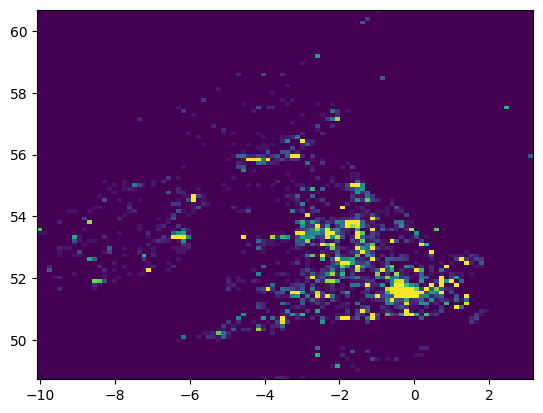

In [6]:
def plot_geotweet_locations(x: list[tuple[str, str, str, float, float]]) -> None:
    # Get geotweet lat/lon pairs from raw data
    tweet_lat_lon = np.asarray([u[3:] for u in x], dtype=float)
    # throw out any bad geotweet locations
    good = ~np.isnan(tweet_lat_lon.sum(axis=1))

    # plot the geotweet locations
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.hist2d(tweet_lat_lon[good,1], tweet_lat_lon[good,0], bins=100, vmax=20);

plot_geotweet_locations(used_data)

In [54]:
def build_vocabulary(packed_data: list[tuple[list[str], list[str], float, float, int]], 
                     word_index: int = 0, 
                     min_word_count: int = 2) -> tuple[list[str], dict[str, int], dict[int, str]]:
    """
    Build a vocabulary from processed tweet data with filtering criteria.
    
    Creates a vocabulary by extracting words/hashtags from tweets and filtering based on
    frequency thresholds. Words must appear at least min_word_count times to be included.
    
    Args:
        packed_data: List of processed tweet tuples, each containing:
            - htags (list[str]): Hashtags from the tweet
            - words (list[str]): Filtered words from the tweet
            - lat (float): Latitude
            - lon (float): Longitude
            - date (int): Date as integer
        word_index: Index to select which list to use for vocabulary (0=hashtags, 1=words).
                   Default is 0 for hashtags.
        min_word_count: Minimum number of times a word must appear to be included in
                       vocabulary. Default is 2.
    
    Returns:
        tuple: A 2-tuple containing:
            - valid_words (list[str]): List of words/hashtags that passed filtering criteria
            - word_map (dict[str, int]): Dictionary mapping each valid word to a unique
                                        integer ID (starting from 1)
            - inv_word_map (dict[int, str]): Inverse mapping of word_map.
    
    Notes:
        - Counts both total word frequency and document frequency
        - Only includes words that appear in at least min_word_count tweets
        - Word IDs start from 1 (not 0) to reserve 0 for special tokens if needed
    """
    idx = word_index
    
    # Count total frequency of each word across all tweets
    word_fre_count = ops.count_by_value([w for u in packed_data for w in u[idx]])
    
    # Count how many documents (tweets) each word appears in
    word_doc_count = ops.count_by_value([w for u in packed_data for w in set(u[idx])])
    
    num_tweet = len(packed_data)
    max_tweet = num_tweet * 1.0
    
    # Filter words: must appear at least min_word_count times and not in every tweet
    valid_words = [v[0] for v in filter(
        lambda u: (u[1] >= min_word_count) and (word_doc_count[u[0]] <= max_tweet), 
        word_fre_count.items()
    )]
    
    # Create mapping from words to integer IDs (starting from 1)
    word_map = dict(zip(valid_words, range(1, len(valid_words) + 1)))

    # get inverse word mapping 
    inv_word_map = {v: k for k, v in word_map.items()}
    
    return valid_words, word_map, inv_word_map

# Build vocabulary from hashtags (index 0)
valid_words, word_map, inv_word_map = build_vocabulary(packed_data, word_index=0, min_word_count=2)

In [55]:
print(f"Number of valid hashtags: {len(valid_words)}")

Number of valid hashtags: 1225


In [56]:
def prepare_model_data(packed_data: list[tuple[list[str], list[str], float, float, int]], 
                      word_map: dict[str, int],
                      word_index: int = 0) -> list[tuple[list[int], tuple[float, float]]]:
    """
    Transform processed tweet data into the format required for joint mixture modeling.
    
    Converts word strings to integer IDs and pairs them with geographic coordinates,
    filtering out invalid entries (empty word lists or invalid coordinates).
    
    Args:
        packed_data: List of processed tweet tuples, each containing:
            - htags (list[str]): Hashtags from the tweet
            - words (list[str]): Filtered words from the tweet
            - lat (float): Latitude coordinate
            - lon (float): Longitude coordinate
            - date (int): Date as integer
        word_map: Dictionary mapping words/hashtags to integer IDs
        word_index: Index to select which word list to use (0=hashtags, 1=words).
                   Default is 0 for hashtags.
    
    Returns:
        list: List of tuples, each containing:
            - word_ids (list[int]): List of integer IDs for words in vocabulary
            - coordinates (tuple[float, float]): (latitude, longitude) pair
    
    Notes:
        - Only includes tweets with at least one valid word in the vocabulary
        - Filters out tweets with NaN or infinite coordinate values
        - Words not in word_map are silently excluded
    """
    idx = word_index
    
    # Map words to integer IDs and pair with coordinates
    grouped_data = [
        ([word_map[v] for v in filter(lambda w: w in word_map, u[idx])], (u[2], u[3])) 
        for u in packed_data
    ]
    
    # Filter out entries with empty word lists or invalid coordinates
    grouped_data = list(filter(
        lambda u: len(u[0]) > 0 and np.isfinite(u[1][0]) and np.isfinite(u[1][1]), 
        grouped_data
    ))
    
    return grouped_data

# Prepare data for modeling
grouped_data = prepare_model_data(packed_data, word_map, word_index=0)

Each entry of our data is now `tuple[list[int], tuple[float, float]]`. Each entry represents a pair of the list of hashtags (mapped to the integers) and a corresponding lat/lon pair for the geotweet location.  

In [57]:
grouped_data[100]

([125, 126, 127], (50.8429, -0.1313))

We are going to build up a model for our data. Since we will utilize a `JointMixtureEstimator`, we will need to define two estimators

1. An estimator for the sequence of words (integers)
2. An estimator for the geotweet locations (lat/lon)

For the hashtags, we will use an `IntegerCategoricalEstimator` and wrap it with a `SequenceEstimator`. 

In [58]:
# pseudo_count = 1.0 is set to flatten the probabilties on the hashtags
word_est = IntegerCategoricalEstimator(min_val=0, max_val=len(word_map), pseudo_count=1.0)
hashtag_est = SequenceEstimator(estimator=word_est)

For the lat/lon pairs we are going to use a `GaussianEstimator` for both the lat and lon. We can wrap the tuple with a `CompositeEstimator`. Notice the estimator has `pseudo_count=(0.0,1.0), suff_stat=(0.0,0.1))]*2` arguments passed. This is to simply regularize the estimate of variance for the lat/lon in each mixture component. This will help us avoid any numeric issues. 

In [59]:
lat_lon_est = CompositeEstimator([GaussianEstimator(pseudo_count=(0.0,1.0), suff_stat=(0.0,0.1))]*2)

Now we can simply define our `JointMixtureEstimator`. We will set `nmix1` topics for the hashtags and `nmix2` for the lat/lon locations. Again we pass in `pseudo_count=(1.0, 1.0, 1.0)` to flatten both sets of topics, the transition matrix, and initial state probabilties. 

In [60]:
nmix1, nmix2 = 10, 200
iest = JointMixtureEstimator(estimators1=[hashtag_est]*nmix1, estimators2=[lat_lon_est]*nmix2, pseudo_count=(1.0,1.0,1.0))
est = JointMixtureEstimator(estimators1=[hashtag_est]*nmix1, estimators2=[lat_lon_est]*nmix2)

All that is left to do is fit the model...

In [61]:
model = optimize(
    data=grouped_data, 
    estimator=est,
    init_estimator=iest, 
    max_its=100, 
    rng=np.random.RandomState(1),
    init_p=0.10,
    print_iter=25)

Iteration 25: ln[p_mat(Data|Model)]=-4.351347e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.653034e+02
Iteration 50: ln[p_mat(Data|Model)]=-4.193387e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.344113e+01
Iteration 50: ln[p_mat(Data|Model)]=-4.193387e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.344113e+01
Iteration 75: ln[p_mat(Data|Model)]=-4.157631e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.225616e+00
Iteration 75: ln[p_mat(Data|Model)]=-4.157631e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.225616e+00
Iteration 100: ln[p_mat(Data|Model)]=-4.142223e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.626035e+00
Iteration 100: ln[p_mat(Data|Model)]=-4.142223e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=5.626035e+00


Let's analyze our fit and see what type on inferences can be made from this model fit. First let's plot the geotweet centeres from each of the `200` topics.

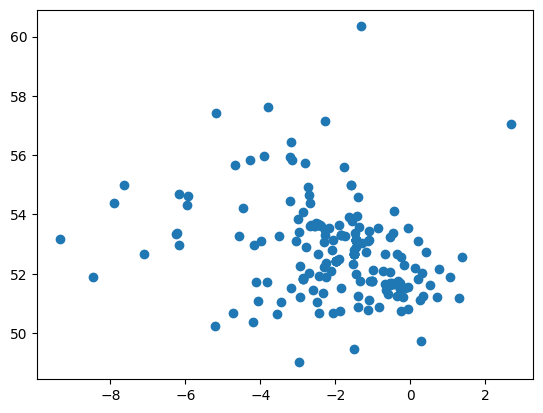

In [62]:
def plot_geotweet_topic_centers(model: JointMixtureDistribution) -> None:
    """Plot the topics centers for the geotweet locations.
    
    Args:
        model (JointMixtureDistribution): Fit to hashtags and geotweet locations.
        
    """
    points = np.asarray([[u.dists[0].mu, u.dists[1].mu] for u in model.components2])
    fig, ax = plt.subplots()

    ax.scatter(points[:,1], points[:,0]);

plot_geotweet_topic_centers(model)


### What topics are dicussed in different geo-locations?

We can approach this analysis in the following manner:

1. Consider all 10 topics for the hashtags. 
2. In each of the topics, look at the distribution enduced by the geotweet locations. 
3. List out the top most common hashtags for each topic. 

What we achieve by this approach is a visual representation of the spatial distribution (lat/lon) for groups of hashtags. For each of the 10 hashtag topics we consider the mixture distribution

$$P(X_{2} | Z_{1} = z_1) = \sum_{z_2=1}^{200} P(X_{2} | Z_{2} = z_{2}) P(Z_2 = z_2 \vert Z_{1} = Z_{1})$$

where $X_2$ represents a geotweet location (lat/lon). Now each topic represents a latent grouping of the hashtags. We will simply peak into the joint mixture component for the hashtags $P(X_1 \vert Z_{1} = z_1)$ and order the hashtags by their likelihood. The result will allow us to plot down the geotweet distributions for each of the hashtag topics along with the most common hashtags in each topic. This should give us an idea of what tweets are posted where. 

In [67]:
def plot_geotweet_spatial_distributions():

    # First we are going to make a common grid over the locations
    xx = np.asarray([u[1][0] for u in grouped_data])
    yy = np.asarray([u[1][1] for u in grouped_data])

    xg,yg = np.meshgrid(np.linspace(xx.min(),xx.max(), 150), np.linspace(yy.min(),yy.max(), 150))

    # we are going to obtain the points from the grid to evaluate P(X_2 | Z_1 = i) for each hashtag topic i.
    pmat = list(zip(xg.flatten(), yg.flatten()))
    # For speed, we are going to encode our data with a "fake" mixture
    enc_locations = seq_encode(data=pmat, model=MixtureDistribution(model.components2, model.taus12[0, :]))[0][1]

    # we will also sequence encode the valid_words (hashtags)
    enc_hashtags = seq_encode(data=[word_map[u] for u in valid_words], model=model.components1[0].dist)[0][1]

    # get inverse word_mapping


    # for each to the hashtag topics
    for i in range(model.num_components1):

        # Form the mixture model P(X_2 | Z_2=z_2) P(Z_2=z_2 | Z_1 = i)
        lmodel = MixtureDistribution(model.components2, model.taus12[i,:])
        # evaluate the log density at all grid points for plot P(X_2 | Z_2 = i)
        llmat = lmodel.seq_log_density(enc_locations)
        # Reshape the log-likelihoods to the shape of the mesh grid
        llmat = np.reshape(llmat, xg.shape)
        # Normalize to form a density over the grid
        llmat -= llmat.max()
        llmat = np.exp(llmat)
        llmat /= llmat.sum()
        # make sure any bad points are set to density of 0
        llmat[~np.isfinite(llmat)] = 0
        
        # Plot normalized geotweet density for the given hashtag topic
        fig,ax = plt.subplots()
        cc = ax.pcolormesh(yg, xg, llmat)
        cc.set_clim(np.percentile(llmat.flatten(), 5.0),np.percentile(llmat.flatten(), 99.0))
        fig.colorbar(cc)
        ax.set_title('Topic '+ str(i))

        # Get log(P(X_1 | Z_1 = i)) likelihood for hashtags
        llword = model.components1[i].dist.seq_log_density(enc_hashtags)
        # sort the hashtags in the topic by index
        top_20_words = ", ".join([inv_word_map[w+1] for w in np.argsort(-llword)[:20].tolist()])
        print("".join([str(i), ": ", top_20_words]))
        

0: #nowplaying, #eustorm, #cumbria, #photo, #brampton, #northants, #bedfordshire, #wallsend, #socialmedia, #fashion, #beepbeep, #cambridgeshire, #beautiful, #warwickshire, #england, #weekend, #seo, #travel, #wwenewcastle, #family
1: #job, #hiring, #careerarc, #jobs, #london, #sales, #engineering, #it, #dublin, #pharmaceutical, #bristol, #birmingham, #cork, #skilledtrade, #retail, #transportation, #o2jobs, #manchester, #marketing, #reading
2: #ukweather, #essex, #stalbans, #weather, #harpenden, #vocab, #yoga, #clacton, #herts, #suffolk, #bungay, #latinvocab, #latin, #spanishvocab, #spanish, #southend, #hampshire, #whr, #porthmadog, #weatherhutton
3: #turriff, #photo, #edinburgh, #scotland, #london, #art, #business, #photography, #clouds, #love, #sunset, #sky, #uk, #architecture, #marketing, #food, #beach, #foodie, #canon, #photoshoot
4: #areacode, #tnc, #weather, #derbyshire, #devon, #gloucestershire, #cheshire, #cornwall, #herefordshire, #evesham, #sheffield, #dawlish, #kernow, #exeter

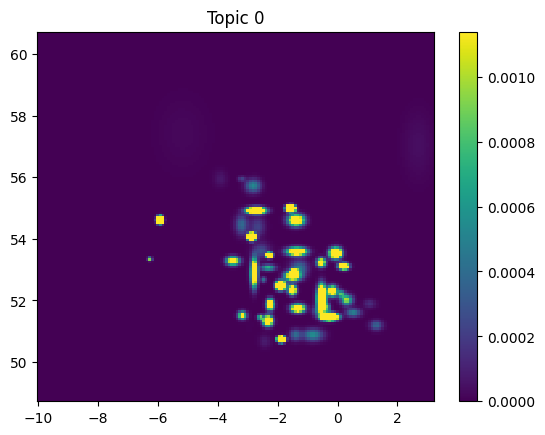

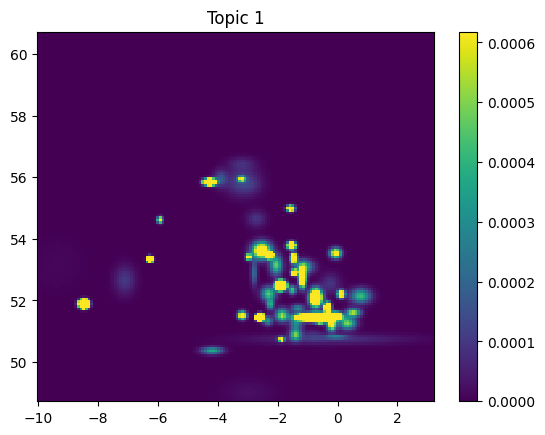

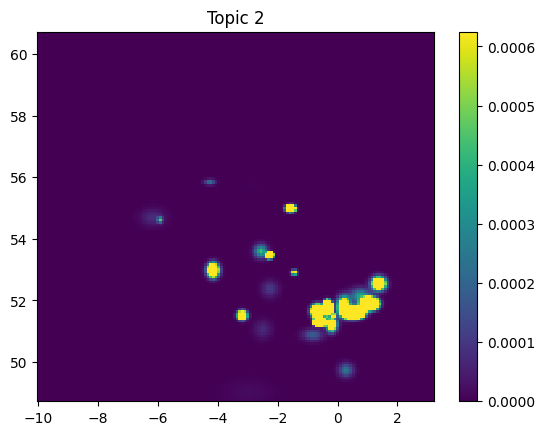

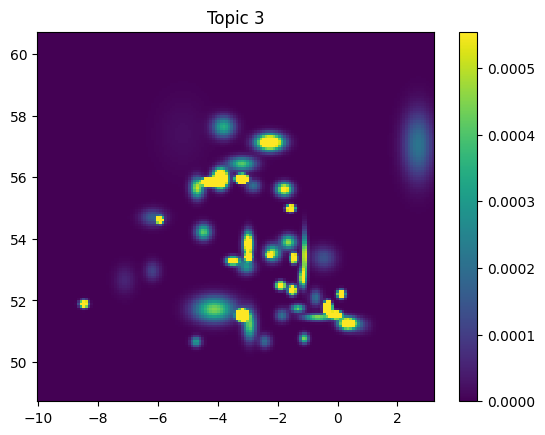

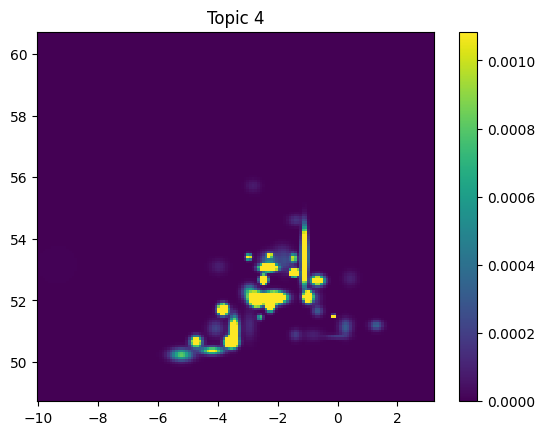

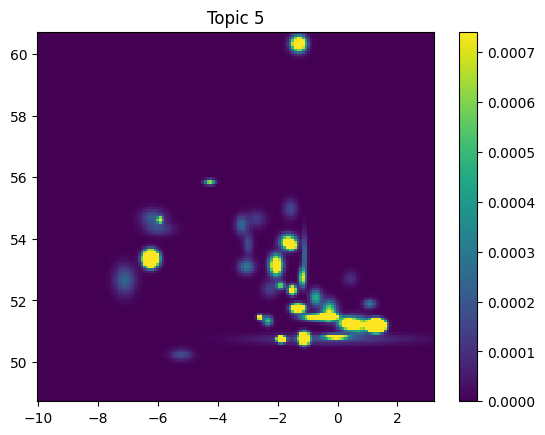

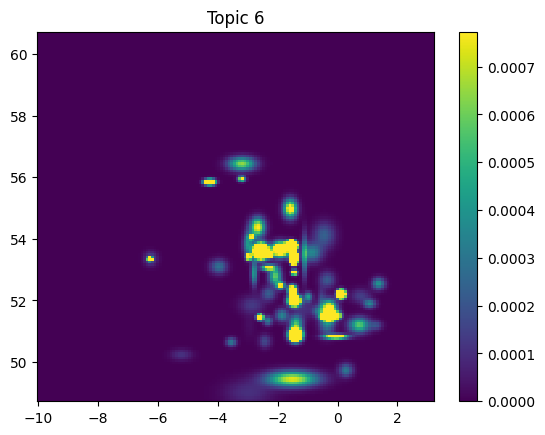

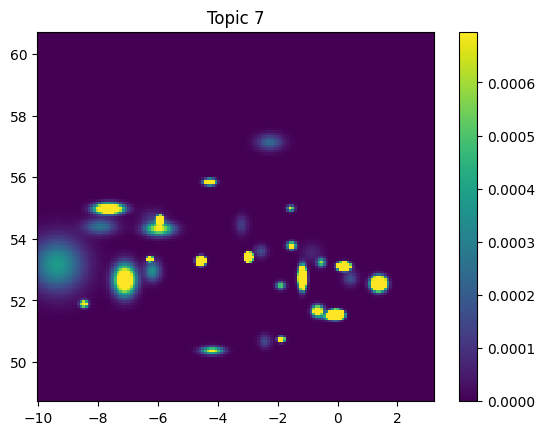

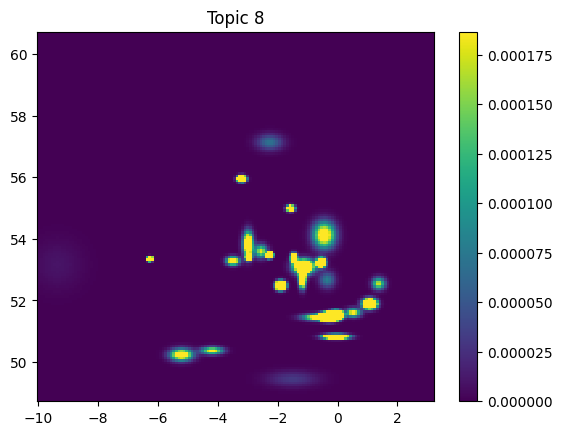

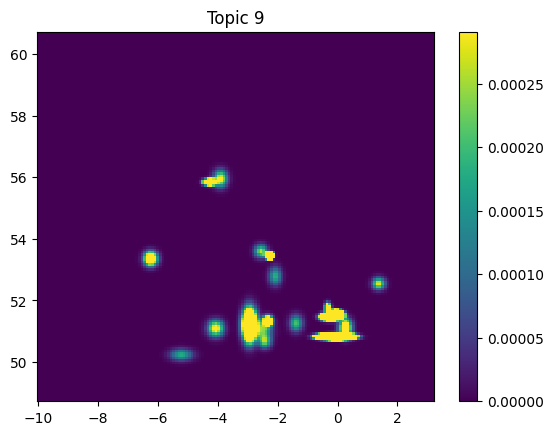

In [68]:
plot_geotweet_spatial_distributions()

### Where is the most likely location a given hastag will be tweeted from?

In the previous case we considered the latent spatial groupings of tweets based on their hashtags. We can also consider the spatial distribution for individual hashtags. We will simply evaluate 

$$P(X_2 = x_2 \vert X_1 = x_1) = \frac{P(X_1 = x_1, X_2 = x_2)}{\sum_{x_2} P(X_1 = x_1, X_2 = x_2)} $$

with calls to the density of the `JointMixtureDistribution`. 




In [109]:
def get_word_density(lookup: list[str], 
                     model: JointMixtureDistribution,
                     word_map: dict[str, int],
                     grouped_data: list[tuple[list[int], tuple[float, float]]],
                     grid_size: int = 100) -> None:
    """
    Compute and visualize the geographic density distribution for given hashtags.
    
    For a given set of hashtags, computes the joint probability density P(X_0, X_1)
    where X_0 is the hashtag(s) and X_1 is the geographic location. Produces two plots:
    1. Posterior probability: How likely each location is relative to other queried hashtags
    2. Density: The normalized probability density over the geographic region
    
    Args:
        lookup: List of hashtags to query (e.g., ['#food', '#london'])
        model: Trained JointMixtureDistribution model
        word_map: Dictionary mapping hashtags to integer IDs
        grouped_data: Processed tweet data with coordinates
        grid_size: Resolution of the spatial grid for visualization. Default is 100.
    
    Notes:
        - Creates a mesh grid over the geographic bounds of the data
        - Computes log-density for all grid points given the hashtag(s)
        - Normalizes to form probability distributions
        - Applies floor threshold to avoid numerical issues
    """
    
    # Set up geographic grid bounds
    xx = np.asarray([u[1][0] for u in grouped_data])
    yy = np.asarray([u[1][1] for u in grouped_data])
    
    xg, yg = np.meshgrid(np.linspace(xx.min(), xx.max(), grid_size), 
                         np.linspace(yy.min(), yy.max(), grid_size))
    
    # Create grid points and pair with the lookup hashtags
    pmat = list(zip(xg.flatten(), yg.flatten()))
    pmat = [([word_map[w] for w in lookup], u) for u in pmat]
    
    # Compute log-density P(hashtags, location) for all grid points
    llmat = model.seq_log_density(model.dist_to_encoder().seq_encode(pmat))
    llmat -= llmat.max()
    llmat = np.reshape(llmat, xg.shape)
    
    # Convert to probability density
    dmat = np.exp(llmat)
    dmat /= dmat.sum()
    
    # Apply floor to avoid numerical issues
    dmat[dmat < 1/xg.size] = 1/xg.size
    dmat /= dmat.sum()
    
    # Create plot with colorbar
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # Create pcolormesh plot
    cc1 = ax1.pcolormesh(yg, xg, dmat, cmap='viridis')
    
    # Set color limits to highlight the data range (5th to 99th percentile)
    cc1.set_clim(np.percentile(dmat.flatten(), 5.0), 
                 np.percentile(dmat.flatten(), 99.0))
    
    # Add colorbar to show the scale
    fig.colorbar(cc1, ax=ax1, label='Probability Density')
    
    ax1.set_title('Density / ' + ', '.join(lookup))
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()


We produce the density plots for $P(X_2=x_2 \vert X_1 = \text{hashtag})$ below. Note that you can also consider a set of hashtags such as `[#love, #food]` if you wanted to.

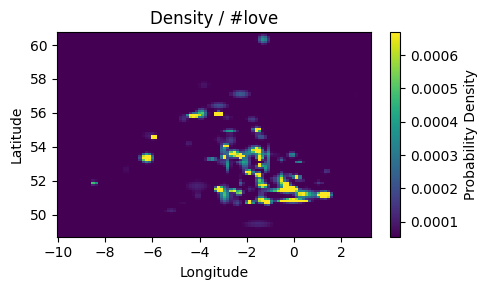

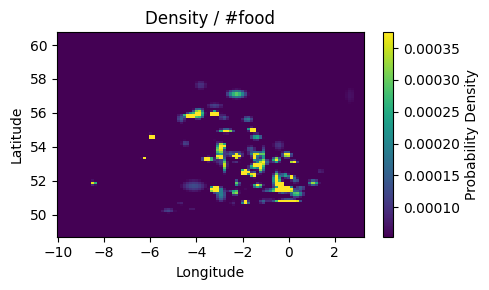

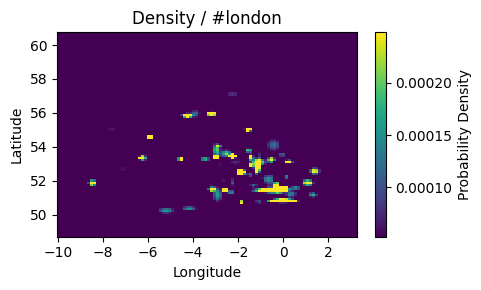

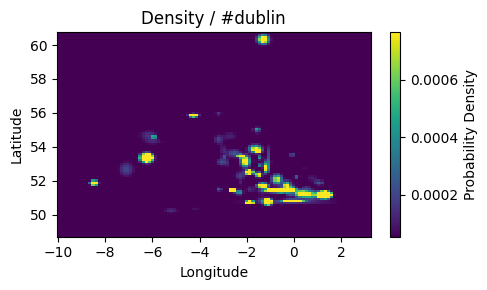

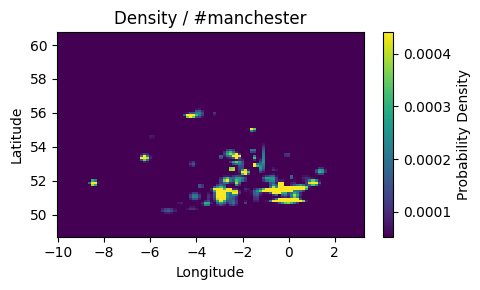

In [110]:
# Example: Visualize density for several hashtags
lookups = [['#love'], ['#food'], ['#london'], ['#dublin'], ['#manchester']]

for lookup in lookups:
    get_word_density(lookup, model, word_map, grouped_data)

### What is the most likely hashtag at a given geographic location? 

This can be answered by considering the densities from before and normalizing over the densities at each location for each word. That is, assuming $P(X_1=x_1) = \frac{1}{\text{\# hashtag lookups}}$, we can simply normalize our previous density evaluations over the set of words at each location

$$P(X_1 = x_1 \vert X_2 = x_2) = \frac{P(X_2 = x_2 \vert X_1 = x_1) P(X_1 = x_1)}{\sum_{x_1} P(X_2 = x_2 \vert X_1 = x_1) P(X_1 = x_1)}  = \frac{P(X_2 = x_2 \vert X_1 = x_1)}{\sum_{x_1} P(X_2 = x_2 \vert X_1 = x_1)}$$

We are going to restrict our search to a set of hashtags, but in theory nothing is stopping you from forming this distribution over all of the tweets.

In [107]:
def posterior_word_density_plots(
        lookups: list[list[str]], 
        model: JointMixtureDistribution,
        word_map: dict[str, int],
        grouped_data: list[tuple[list[int], tuple[float, float]]],
        grid_size: int = 100) -> None:
    """
    Compute and visualize both density and posterior probability for multiple hashtags.
    
    For each hashtag a a plot of the posterior probability P(hashtag | location): over the passed 
        hashtag lookups is produced
    
    Args:
        lookups: List of hashtag lists to analyze (e.g., [['#food'], ['#london']])
        model: Trained JointMixtureDistribution model
        word_map: Dictionary mapping hashtags to integer IDs
        grouped_data: Processed tweet data with coordinates for determining grid bounds
        grid_size: Resolution of the spatial grid. Default is 100.
    
    Notes:
        - Posterior is computed as: P(word|location) ∝ P(word, location) / Σ_words P(word, location)
        - Posterior sums to 1 across all hashtags at each location
        - Density is normalized over the entire geographic grid for each hashtag
        - Both plots use percentile-based color limits for better visualization
    """
    
    # Set up geographic grid bounds from the data
    xx = np.asarray([u[1][0] for u in grouped_data])
    yy = np.asarray([u[1][1] for u in grouped_data])

    # Create mesh grid for evaluating densities
    xg, yg = np.meshgrid(np.linspace(xx.min(), xx.max(), grid_size), 
                         np.linspace(yy.min(), yy.max(), grid_size))

    # Initialize array to store densities for all hashtags
    # Shape: (grid_height, grid_width, num_hashtags)
    dmats = np.zeros((xg.shape[0], xg.shape[1], len(lookups)))

    # Compute density P(hashtag, location) for each hashtag
    for i, lookup in enumerate(lookups):
        # Create grid of (hashtag, location) pairs
        pmat = list(zip(xg.flatten(), yg.flatten()))
        pmat = [([word_map[w] for w in lookup], u) for u in pmat]

        # Evaluate log P(hashtag, location) at all grid points
        llmat = model.seq_log_density(model.dist_to_encoder().seq_encode(pmat))
        llmat -= llmat.max()  # Numerical stability
        llmat = np.reshape(llmat, xg.shape)
        
        # Convert to probability and normalize over the grid
        dmat = np.exp(llmat)
        dmat /= dmat.sum()
        
        # Apply floor to avoid numerical issues with very small probabilities
        dmat[dmat < 1/xg.size] = 1/xg.size
        dmat /= dmat.sum()
        
        # Store density for this hashtag
        dmats[:, :, i] = dmat

    # Compute posterior P(hashtag | location) by normalizing across hashtags at each location
    # At each location, posterior shows which hashtag is most likely
    dmats = dmats / (dmats.sum(axis=2, keepdims=True)) 
        
    # Create visualization for each hashtag
    for i, lookup in enumerate(lookups):   
        fig, ax1= plt.subplots(figsize=(5, 3))
        
        # Left plot: Posterior probability P(hashtag | location)
        cc1 = ax1.pcolormesh(yg, xg, dmats[:, :, i])
        cc1.set_clim(0, 2/len(lookups))  # Uniform prior would be 1/len(lookups)
        ax1.set_title('Posterior / ' + ', '.join(lookup))
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        fig.colorbar(cc1, ax=ax1, label='Posterior Probability')
        
        
        plt.tight_layout()


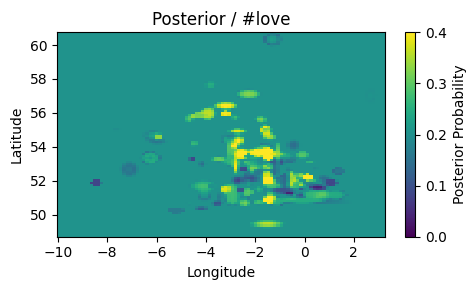

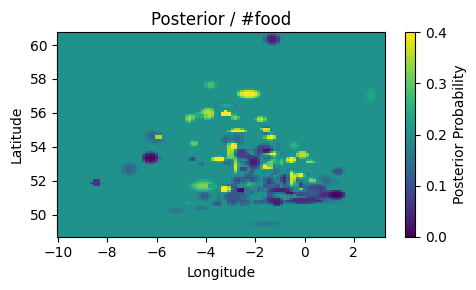

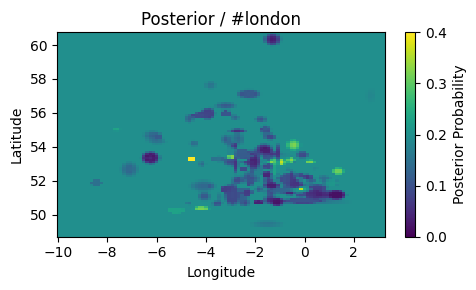

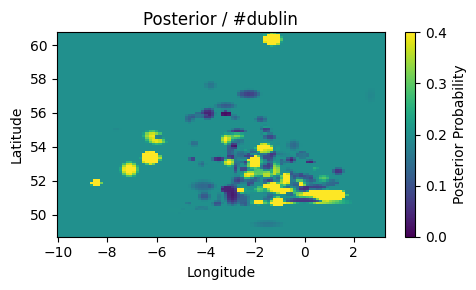

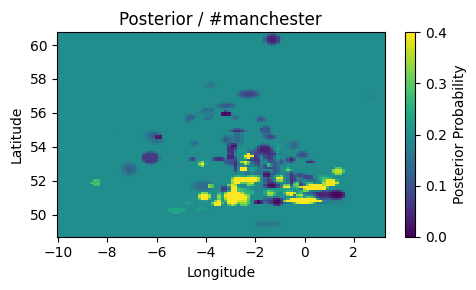

In [108]:
lookups = [['#love'],  ['#food'], ['#london'], ['#dublin'], ['#manchester']]
posterior_word_density_plots(lookups=lookups, model=model, word_map=word_map, grouped_data=grouped_data)